### Imports

In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
import keras as k

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from keras.initializers import GlorotUniform

from matplotlib import pyplot as plt
import seaborn as sns
import scipy

from datetime import datetime

import pickle

from PIL import Image

from custom_class import *

print(f"pd.__version__: {pd.__version__}")
print(f"tf.__version__: {tf.__version__}")

2025-02-26 20:19:34.403025: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 20:19:34.432212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-26 20:19:34.432245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-26 20:19:34.433248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 20:19:34.438891: I tensorflow/core/platform/cpu_feature_guar

pd.__version__: 2.2.3
tf.__version__: 2.15.1


### Read file path and labels to list

In [2]:
dataset_dir = "/mnt/c/Users/psamt/OneDrive - The University of Nottingham/_Spring/PHYS4036_Machine Learning in Science Part II/Project/Dataset/machine-learning-in-science-ii-2025"
# dataset_dir = "/kaggle/input/machine-learning-in-science-ii-2025"

csv_path = os.path.join(dataset_dir, "training_norm.csv")
csv_df = pd.read_csv(csv_path, index_col="image_id")

training_data_dir = os.path.join(dataset_dir, "training_data", "training_data")

# there is one speed > 1. So change it.
csv_df.loc[csv_df["speed"] > 1, "speed"] = 1

csv_df.drop(columns=["speed"], inplace=True)

display(csv_df)

,angle
image_id,
1,0.4375
2,0.8125
3,0.4375
4,0.6250
5,0.5000
...,...
13794,0.6250
13795,0.4375
13796,0.5625


Check the data

(array([  88.,  197.,  104.,  641., 1467., 3655., 3970., 2123., 1448.,
         100.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

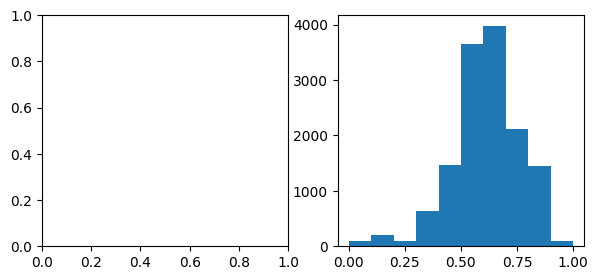

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))
ax[1].hist(csv_df["angle"])

0.00000 60
0.06250 28
0.12500 99
0.18750 98
0.25000 104
0.31250 213
0.37500 428
0.43750 1467
0.50000 2046
0.56250 1609
0.62500 1963
0.68750 2007
0.75000 2123
0.81250 1147
0.87500 301
0.93750 65
1.00000 35
{0.0: 60, 0.0625: 28, 0.125: 99, 0.1875: 98, 0.25: 104, 0.3125: 213, 0.375: 428, 0.4375: 1467, 0.5: 2046, 0.5625: 1609, 0.625: 1963, 0.6875: 2007, 0.75: 2123, 0.8125: 1147, 0.875: 301, 0.9375: 65, 1.0: 35}


<BarContainer object of 17 artists>

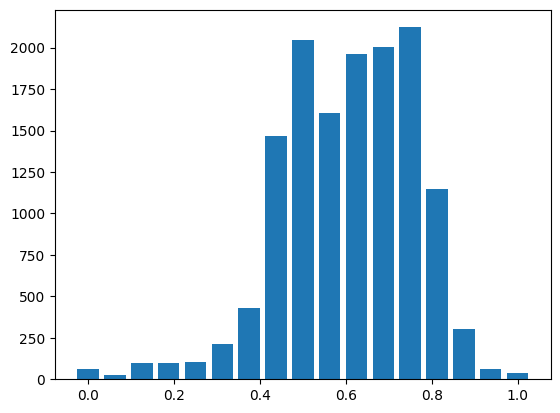

In [4]:
angle = csv_df["angle"]

df = pd.DataFrame(angle)
bins = np.unique(angle)
c = df["angle"].value_counts()

angle_count = {}

for bin in bins:
    angle_count[bin] = c[bin]

key, value = list(angle_count.keys()), list(angle_count.values())

for i in range(len(key)):
    print(f"{key[i]:.5f} {value[i]}")

print(angle_count)

plt.bar(key, value, width=0.05)

In [5]:
# for rs in range(10000):
#     X = np.array(csv_df.index)
#     y = np.array(csv_df['angle'])
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=rs)
#     X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(0.15/0.85), random_state=rs)

#     # print(X_train.shape)
#     # print(X_val.shape)
#     # print(X_test.shape)
#     # print(X.shape)

#     train_count = pd.Series(y_train).value_counts()
#     train_count = train_count / sum(train_count) * 100
#     # val_count = pd.Series(y_val).value_counts()
#     # val_count = val_count / sum(val_count) * 100
#     # test_count = pd.Series(y_test).value_counts()
#     # test_count = test_count / sum(test_count) * 100

#     ori_count = pd.Series(y).value_counts()
#     ori_count = ori_count / sum(ori_count) * 100

#     diff = (sum(abs(train_count-ori_count)))

#     if (diff < 0.6):
#         print(f"random state: {rs}")
#         print(diff)

#     bar_width = 0.015
#     # plt.bar(val_count.index-bar_width, train_count, width=bar_width)
#     # plt.bar(train_count.index, train_count, width=bar_width)
#     # plt.bar(ori_count.index+bar_width, train_count, width=bar_width)
#     # plt.bar(test_count.index+bar_width, train_count, width=bar_width)

random state: 5695
0.4295065874309431


<BarContainer object of 17 artists>

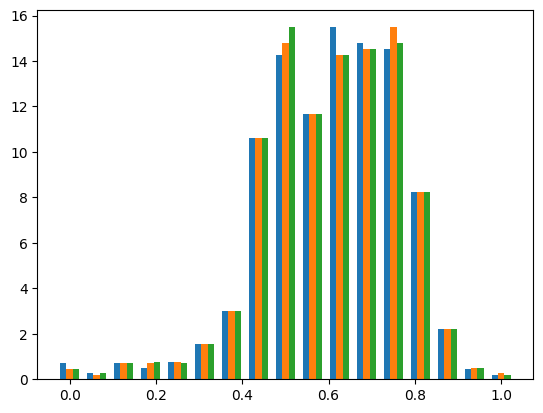

In [6]:
rs = 5695
X = np.array(csv_df.index)
y = np.array(csv_df["angle"])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=rs
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=(0.15 / 0.85), random_state=rs
)

train_count = pd.Series(y_train).value_counts()
train_count = train_count / sum(train_count) * 100
val_count = pd.Series(y_val).value_counts()
val_count = val_count / sum(val_count) * 100
test_count = pd.Series(y_test).value_counts()
test_count = test_count / sum(test_count) * 100

ori_count = pd.Series(y).value_counts()
ori_count = ori_count / sum(ori_count) * 100

diff = sum(abs(train_count - ori_count))

if diff < 0.7:
    print(f"random state: {rs}")
    print(diff)

bar_width = 0.015
plt.bar(val_count.index - bar_width, train_count, width=bar_width)
plt.bar(train_count.index, train_count, width=bar_width)
# plt.bar(ori_count.index+bar_width, train_count, width=bar_width)
plt.bar(test_count.index + bar_width, train_count, width=bar_width)

In [7]:
train_count = pd.Series(y_train).value_counts().sort_index()
train_total = np.sum(train_count)

weight = train_total / (len(train_count) * train_count)
weight = weight / min(weight)

lower, upper = (0, 1)
weight = weight.apply(lambda x: x if x < upper else upper)
weight = weight.apply(lambda x: x if x > lower else lower)


p_for_random_choice = weight[y_train].values

p_for_random_choice = p_for_random_choice / sum(p_for_random_choice)

print(weight)

0.0000    1
0.0625    1
0.1250    1
0.1875    1
0.2500    1
0.3125    1
0.3750    1
0.4375    1
0.5000    1
0.5625    1
0.6250    1
0.6875    1
0.7500    1
0.8125    1
0.8750    1
0.9375    1
1.0000    1
Name: count, dtype: int64


In [8]:
# # Define generator for weighted sampling
# def sample_generator(X, y, sample_probs):
#     idx = np.random.choice(len(y), p=sample_probs)  # Sample index
#     return X[idx], y[idx]


# X_train_os = []
# y_train_os = []

# for i in range(10240):
#     X_sampled, y_sampled = sample_generator(X_train, y_train, p_for_random_choice)
#     X_train_os.append(X_sampled)
#     y_train_os.append(y_sampled)

# # for i in range(10):
# #     print(X_train_os[i], y_train_os[i])
# #     print(csv_df.loc[X_train_os[i]]['angle'])

# # print(pd.Series(y_train).value_counts().sort_index())

# # print(pd.Series(y_train_os).value_counts().sort_index())

# y_train_os_count = pd.Series(y_train_os).value_counts().sort_index()

# plt.bar(list(y_train_os_count.index), y_train_os_count, width=0.04)
# plt.title("Over sampled")

In [9]:
sample_probs_tensor = tf.constant(p_for_random_choice, dtype=tf.float32)

X_train_tensor = tf.constant(X_train, dtype=tf.int32)
y_train_tensor = tf.constant(y_train, dtype=tf.float32)

NUM_SAMPLES = 32*400

def sample_indices():
    return tf.random.categorical(tf.math.log([sample_probs_tensor]), NUM_SAMPLES)[0]

sampled_indices = sample_indices()

X_train_os = tf.gather(X_train_tensor, sampled_indices)
y_train_os = tf.gather(y_train_tensor, sampled_indices)

train_ds = tf.data.Dataset.from_tensor_slices((X_train_os, y_train_os))

2025-02-26 20:19:37.329628: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-26 20:19:37.365217: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-26 20:19:37.365263: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-26 20:19:37.370173: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-02-26 20:19:37.370218: I external/local_xla/xla/stream_executor

In [10]:
ids = []
angles = []
for id, angle in train_ds:
    ids.append(id.numpy())
    angles.append(angle.numpy())

Text(0.5, 1.0, 'Distribution of angles after oversampling')

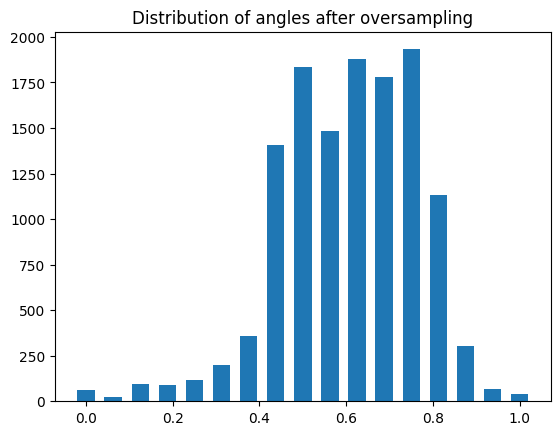

In [11]:
y_count = pd.Series(angles).value_counts().sort_index()
plt.bar(y_count.index, y_count, width=0.04)
plt.title("Distribution of angles after oversampling")

In [12]:
# X_train_os_path = [
#     os.path.join(training_data_dir, str(image_id) + ".png") for image_id in X_train_os
# ]
X_val_path = [
    os.path.join(training_data_dir, str(image_id) + ".png") for image_id in X_val
]

In [13]:
def decode_img(
    img,
):  # -> Any | defaultdict | Any | list | None | object | Tensor | ...:
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path, angle):
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, angle

def image_id_to_path(image_id, angle):
    image_path = tf.strings.join([training_data_dir, '/', tf.as_string(image_id), ".png"])  # Assuming images are .jpg
    return image_path, angle

In [14]:
# train_ds = tf.data.Dataset.from_tensor_slices((X_train_os_path, y_train_os))
train_ds = tf.data.Dataset.from_tensor_slices((X_train_os, y_train_os))
train_ds = train_ds.map(image_id_to_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val))

train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

train_ds_length = tf.data.experimental.cardinality(train_ds).numpy()
print(train_ds_length)
val_ds_length = tf.data.experimental.cardinality(val_ds).numpy()
print(val_ds_length)

12800
2069


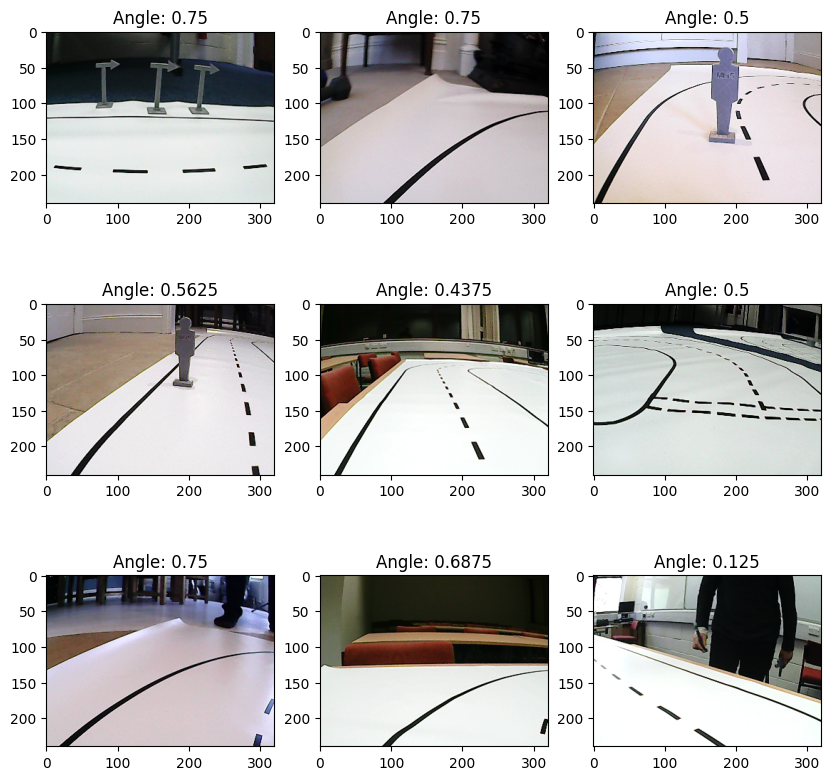

In [15]:
plt.figure(figsize=(10, 10))
i = 0

for image, angle in train_ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("float32"))
    angle = angle.numpy()
    plt.title(f"Angle: {angle}")
    i += 1

In [16]:
def visualise(original, augmented):
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original image")
    plt.imshow(original.numpy().astype("float32"))

    plt.subplot(1, 2, 2)
    plt.title("Augmented image")
    plt.imshow(augmented.numpy().astype("float32"))

In [17]:
rotate_by_degree = 5
random_rotate = keras.layers.RandomRotation(rotate_by_degree / 360)


def augment(image, angle, seed=None):
    # Deal with the random seed
    if seed == None:
        seed = tf.random.uniform(shape=[2], maxval=10000, dtype=tf.int32)
    else:
        seed = tf.constant([seed, seed], dtype=tf.int32)

    image = tf.image.stateless_random_brightness(image, 0.3, seed)
    image = tf.image.stateless_random_contrast(image, 0.75, 1.25, seed)
    image = tf.image.stateless_random_hue(image, 0.05, seed)
    image = tf.image.stateless_random_saturation(image, 0.7, 1.2, seed)
    image = tf.image.stateless_random_jpeg_quality(image, 80, 100, seed)

    image = random_rotate(image)

    # crop image
    image = tf.image.stateless_random_crop(image, size=[210, 280, 3], seed=seed)

    # resize image back to 240x320
    image = tf.image.resize(image, [240, 320])

    return image, angle

Test augment function

20
Augmented image shape: (240, 320, 3)


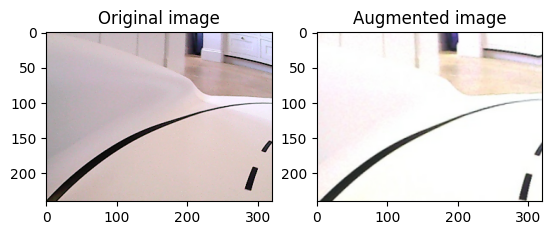

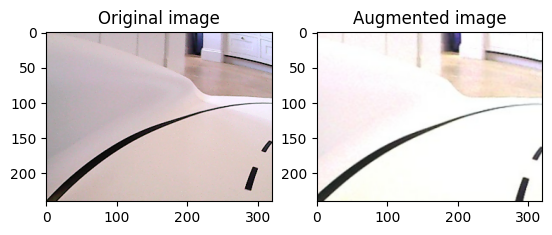

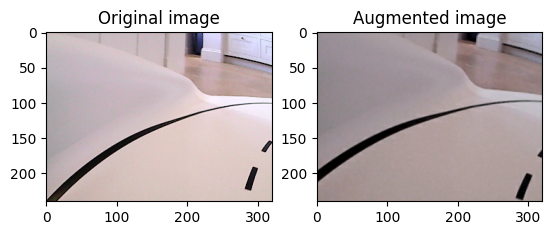

In [18]:
skip = 20
# skip+=1
print(skip)
for i in range(3):
    for image, angle in train_ds.skip(skip).take(1):
        augmented_image, angle = augment(image, angle, None)
        visualise(image, augmented_image)

for image, angle in train_ds.take(1):
    aug_image, aug_angle = augment(image, angle)
    print(f"Augmented image shape: {aug_image.shape}")

In [19]:
train_ds = train_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
def scale_ds(image, speed):
    # Range of input image: [0, 1]
    return image * 2 - 1.0, speed


train_ds = train_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(scale_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [21]:
def rephrase_ds(image, angle):
    return image, {"angle_output": angle}


train_ds = train_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(rephrase_ds, num_parallel_calls=tf.data.AUTOTUNE)

In [22]:
batch_size = 64


def configure_for_performance(ds, shuffle: bool, batch: bool):
    if shuffle:
        ds = ds.shuffle(buffer_size=3000)
    if batch:
        ds = ds.batch(batch_size, drop_remainder=True)
    else:
        ds = ds.batch(1, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


train_ds = train_ds.repeat()
val_ds = val_ds.repeat()
train_ds = configure_for_performance(train_ds, shuffle=True, batch=True)
val_ds = configure_for_performance(val_ds, shuffle=False, batch=True)

### Build model

In [23]:
image_shape = (240, 320, 3)

base_model = keras.applications.MobileNetV3Large(
    include_top=False,
    weights="imagenet",
    input_shape=image_shape,
    pooling=None,
    include_preprocessing=False, 
)
base_model.trainable = False

print(base_model.output.shape)

(None, 8, 10, 960)


In [24]:
feature_extractor = base_model.output

print(feature_extractor.shape)

x = layers.Conv2D(960, (3, 3), activation='relu', padding='same', 
                  kernel_regularizer=tf.keras.regularizers.l2(0.01), 
                  name='angle_conv_1')(feature_extractor)
x = layers.GlobalAveragePooling2D(name='GAP')(x)
x = layers.Dense(128, activation='relu', name='angle_dense_1')(x)
x = layers.Dense(1, activation='sigmoid', name='angle_dense_0')(x)

angle_output = x

model = Model(inputs=base_model.input, outputs={'angle_output': angle_output}, name="my_model")

learning_rate = 0.0010

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss={"angle_output": "mse"},
    metrics={"angle_output": ["mae"]},
)

# model.summary()

(None, 8, 10, 960)


In [25]:
sub_model = Model(feature_extractor, angle_output)
tf.keras.utils.plot_model(
    sub_model,
    show_shapes=True,  # Show input/output shapes
    show_layer_names=True,  # Show layer names (e.g., "angle_hidden_2")
    expand_nested=False,  # Keep it flat (no base_model nesting)
    show_layer_activations=True,
    dpi=96,  # Image resolution
)

print("Saved model image: model.png")

Saved model image: model.png


In [26]:
def lr_schedule(epoch, lr):
    initial_lr = learning_rate
    if epoch == 0:
        return 0.002
        return initial_lr * 2
    decay = 0.3
    return initial_lr / (1 + ((epoch-1) // 3) * decay)

for epoch in range(30):
    print(f"Epoch {epoch+1:2d}: {lr_schedule(epoch, 0):.6f}")

Epoch  1: 0.002000
Epoch  2: 0.001000
Epoch  3: 0.001000
Epoch  4: 0.001000
Epoch  5: 0.000769
Epoch  6: 0.000769
Epoch  7: 0.000769
Epoch  8: 0.000625
Epoch  9: 0.000625
Epoch 10: 0.000625
Epoch 11: 0.000526
Epoch 12: 0.000526
Epoch 13: 0.000526
Epoch 14: 0.000455
Epoch 15: 0.000455
Epoch 16: 0.000455
Epoch 17: 0.000400
Epoch 18: 0.000400
Epoch 19: 0.000400
Epoch 20: 0.000357
Epoch 21: 0.000357
Epoch 22: 0.000357
Epoch 23: 0.000323
Epoch 24: 0.000323
Epoch 25: 0.000323
Epoch 26: 0.000294
Epoch 27: 0.000294
Epoch 28: 0.000294
Epoch 29: 0.000270
Epoch 30: 0.000270


### Train model

In [27]:
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/model_epoch_{epoch:02d}.keras",
    save_weights_only=False,
    save_freq="epoch",
    verbose=1,
)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

history_callback = keras.callbacks.History()

NUM_OF_EPOCHS = 50

try:
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=NUM_OF_EPOCHS,
        steps_per_epoch= train_ds_length // batch_size,
        validation_steps= val_ds_length // batch_size,
        callbacks=[checkpoint, history_callback, lr_scheduler],
        verbose=1,
    )
except KeyboardInterrupt:
    print("Stopped early—saving history")
    with open("training_history.pkl", "wb") as f:
        pickle.dump(history_callback.history, f)


Epoch 1: LearningRateScheduler setting learning rate to 0.002.
Epoch 1/50


2025-02-26 20:19:50.220059: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-02-26 20:19:50.441682: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-02-26 20:19:54.334452: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5f59bd6e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-02-26 20:19:54.334495: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-02-26 20:19:54.338955: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740601194.402142  135805 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - ETA: 0s - loss: 0.4686 - mae: 0.2000
Epoch 1: saving model to checkpoints/model_epoch_01.keras
200/200 [==============================] - 44s 158ms/step - loss: 0.4686 - mae: 0.2000 - val_loss: 0.0948 - val_mae: 0.0807 - lr: 0.0020

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.0231 - mae: 0.0771
Epoch 2: saving model to checkpoints/model_epoch_02.keras
200/200 [==============================] - 30s 152ms/step - loss: 0.0231 - mae: 0.0771 - val_loss: 0.0182 - val_mae: 0.0752 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.0199 - mae: 0.0760
Epoch 3: saving model to checkpoints/model_epoch_03.keras
200/200 [==============================] - 30s 152ms/step - loss: 0.0199 - mae: 0.0760 - val_loss: 0.0160 - val_mae: 0.0672 - lr: 0.0010

Epoch 4: LearningRateSch

2025-02-26 20:44:43.898741: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 15799839644649329344


### Save model and plot

In [28]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M")  # Format: YYYYMMDD_HHMM
name_template = f'angle_model_{timestamp}'

folder_path = f"Models/{name_template}"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

filename = f"{folder_path}/{name_template}.keras"
model.save(filename)
filename = f"{folder_path}/{name_template}.weights.h5"
model.save_weights(filename)

history = history_callback.history

filename = f"{folder_path}/{name_template}_history.pkl"
with open(filename, 'wb') as f:
    pickle.dump(history, f)

['loss', 'mae', 'val_loss', 'val_mae']


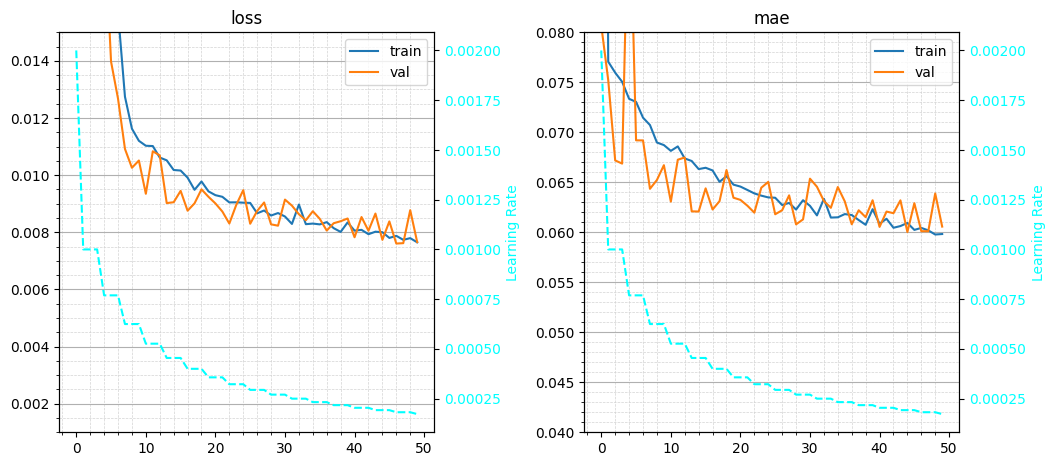

In [29]:
history = history_callback.history
history_1 = history_callback.history

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


ax = ax.ravel()

keys = list(history.keys())
print(keys)
needed = [0, 1]
groups = [keys[i] for i in needed]

for key in history.keys():
    for j in range(len(groups)):
        if key.endswith(groups[j]):
            label = "val" if key.startswith("val") else "train"
            ax[j].plot(history[key], label=label)
            ax[j].set_title(groups[j])
            ax[j].minorticks_on()
            ax[j].grid(True, axis="y")
            ax[j].grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')
            ax[j].legend()
            break

ylim_list = [
    (0.001, 0.015),
    (0.04, 0.08),
]
for i in range(len(groups)):
    # l, u = ylim_list[i]
    ax[i].set_ylim(ylim_list[i])

learning_rates = [lr_schedule(epoch, 1) for epoch in range(len(history['loss']))]

for i in range(len(groups)):
    ax_lr = ax[i].twinx()
    ax_lr.plot(learning_rates, color="cyan", label="Learning Rate", linestyle="--")
    ax_lr.set_ylabel("Learning Rate", color="cyan")
    ax_lr.tick_params(axis="y", labelcolor="cyan")

# ax[1].text(20 ,0,f"OverSampling max {upper}, v2S", rotation=90, ha='center')

# model_details_text = [
#     f"Model details: Batch {batch_size}, LR: {learning_rate}",
#     "EfficientNetV2S",
#     "two paths: ",
#     "GlobalAveragePooling2D+norm+dropout and ",
#     "conv2D(128,(3,3)) -> norm -> flatten",
#     "merge -> norm -> dense(2560) -> dropout",
#     "Split to two 1024 (relu), 512 (relu), 100 (relu), 1",
# ]

# ax[-1].axis("off")
# ax[-2].axis("off")
# ax[-3].axis("off")
# for i in range(len(model_details_text)):
#     ax[-3].text(x=0.5, y=0.9 - i * 0.09, s=model_details_text[i])



plt.savefig(f"{folder_path}/{name_template}.png")

In [30]:
for layer in base_model.layers[-5:]:  # Freeze all but the last 20 layers
    layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss={"angle_output": "mse"},
    metrics={"angle_output": ["mae"]},
)

def lr_schedule_cont(epoch, lr):
    return lr_schedule(epoch+NUM_OF_EPOCHS, lr)

for epoch in range(30):
    print(f"Epoch {epoch+1:2d}: {lr_schedule_cont(epoch, 0):.6f}")

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule_cont, verbose=1)

Epoch  1: 0.000172
Epoch  2: 0.000172
Epoch  3: 0.000164
Epoch  4: 0.000164
Epoch  5: 0.000164
Epoch  6: 0.000156
Epoch  7: 0.000156
Epoch  8: 0.000156
Epoch  9: 0.000149
Epoch 10: 0.000149
Epoch 11: 0.000149
Epoch 12: 0.000143
Epoch 13: 0.000143
Epoch 14: 0.000143
Epoch 15: 0.000137
Epoch 16: 0.000137
Epoch 17: 0.000137
Epoch 18: 0.000132
Epoch 19: 0.000132
Epoch 20: 0.000132
Epoch 21: 0.000127
Epoch 22: 0.000127
Epoch 23: 0.000127
Epoch 24: 0.000122
Epoch 25: 0.000122
Epoch 26: 0.000122
Epoch 27: 0.000118
Epoch 28: 0.000118
Epoch 29: 0.000118
Epoch 30: 0.000114


In [31]:
# try:
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=20,
#         steps_per_epoch= train_ds_length // batch_size,
#         validation_steps= val_ds_length // batch_size,
#         callbacks=[checkpoint, history_callback, lr_scheduler],
#         verbose=1,
#     )
# except KeyboardInterrupt:
#     print("Stopped early—saving history")
#     with open("training_history.pkl", "wb") as f:
#         pickle.dump(history_callback.history, f)

In [32]:
# name_template = f'{name_template}_cont'

# folder_path = f"Models/{name_template}"

# if not os.path.exists(folder_path):
#     os.makedirs(folder_path)

# filename = f"{folder_path}/{name_template}.keras"
# model.save(filename)
# filename = f"{folder_path}/{name_template}.weights.h5"
# model.save_weights(filename)

# history = history_callback.history

# filename = f"{folder_path}/{name_template}_history.pkl"
# with open(filename, 'wb') as f:
#     pickle.dump(history, f)

In [33]:
# history_2 = history_callback.history

# history = {}

# # Merge using numpy.concatenate
# for key in history_1.keys():
#     history[key] = np.concatenate([history_1[key], history_2[key]])

# history = history_callback.history

# fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)


# ax = ax.ravel()

# keys = list(history.keys())
# print(keys)
# needed = [0, 1]
# groups = [keys[i] for i in needed]

# for key in history.keys():
#     for j in range(len(groups)):
#         if key.endswith(groups[j]):
#             label = "val" if key.startswith("val") else "train"
#             ax[j].plot(history[key], label=label)
#             ax[j].set_title(groups[j])
#             ax[j].minorticks_on()
#             ax[j].grid(True, axis="y")
#             ax[j].grid(which='minor', linestyle='--', linewidth=0.5, color='lightgray')
#             ax[j].legend()
#             break

# ylim_list = [
#     (0.001, 0.015),
#     (0.04, 0.08),
# ]
# for i in range(len(groups)):
#     # l, u = ylim_list[i]
#     ax[i].set_ylim(ylim_list[i])

# learning_rates = [lr_schedule(epoch, 1) for epoch in range(len(history['loss']))]

# for i in range(len(groups)):
#     ax_lr = ax[i].twinx()
#     ax_lr.plot(learning_rates, color="cyan", label="Learning Rate", linestyle="--")
#     ax_lr.set_ylabel("Learning Rate", color="cyan")
#     ax_lr.tick_params(axis="y", labelcolor="cyan")

# # ax[1].text(13 ,0,f"OverSampling max {upper}, v2M", rotation=90, ha='center')

# # model_details_text = [
# #     f"Model details: Batch {batch_size}, LR: {learning_rate}",
# #     "EfficientNetV2S",
# #     "two paths: ",
# #     "GlobalAveragePooling2D+norm+dropout and ",
# #     "conv2D(128,(3,3)) -> norm -> flatten",
# #     "merge -> norm -> dense(2560) -> dropout",
# #     "Split to two 1024 (relu), 512 (relu), 100 (relu), 1",
# # ]

# # ax[-1].axis("off")
# # ax[-2].axis("off")
# # ax[-3].axis("off")
# # for i in range(len(model_details_text)):
# #     ax[-3].text(x=0.5, y=0.9 - i * 0.09, s=model_details_text[i])



# plt.savefig(f"{folder_path}/{name_template}.png")

In [34]:
print(len(history_1['loss']))

50
